# Week 3 Peer Review
## Histopathologic Cancer Detection Mini Project
### Introduction to Deep Learning

### Problem Overview (Step 1)

Task: The task is to classify images as containing metastatic cancer cells (positive label) or not (negative label). Specifically, the goal is to identify whether the 32x32px region in the center of each image patch contains at least one pixel of tumor tissue.

Data: The competition gave two sets of data: the training set (with images and labels) and the test set (images without labels). The test set will be used to make predictions for submission to the competition.

Data Description

- Training Data: The training dataset contains images and their corresponding labels, stored in a train folder. The labels are provided in the train_labels.csv file.
- Test Data: The test set contains images stored in the test folder, and your task is to predict the label for each image.
- Labels: A label of 1 indicates the presence of metastatic cancer in the center 32x32px of the patch, while a label of 0 indicates the absence of cancer.
- Image Dimensions: Each image is a 96x96 pixel patch with 3 color channels (RGB).

In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc

In [2]:
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import AUC
from tensorflow.keras.optimizers import Adam

### Step 2: EDA

In [23]:
train_labels = pd.read_csv('train_labels.csv')

train_labels.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


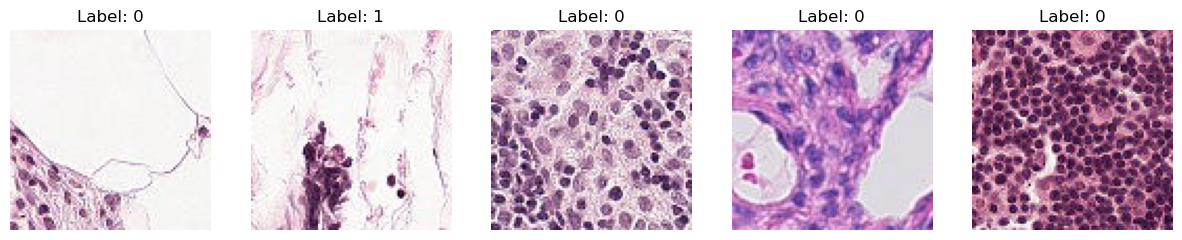

Class distribution:
 label
0    130908
1     89117
Name: count, dtype: int64


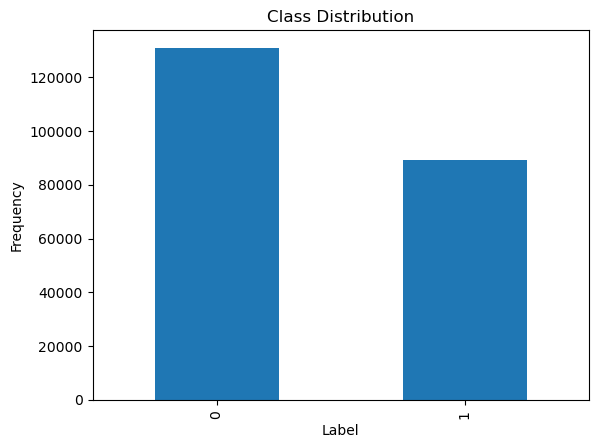

In [24]:
num_images = 5
fig, axes = plt.subplots(1, num_images, figsize=(15, 15))

# Display random images from the 'train' folder
for i in range(num_images):
    img_path = os.path.join('train', train_labels['id'].iloc[i] + '.tif')
    img = mpimg.imread(img_path)
    label = train_labels['label'].iloc[i]
    
    axes[i].imshow(img)
    axes[i].set_title(f'Label: {label}')
    axes[i].axis('off')

plt.show()

label_counts = train_labels['label'].value_counts()

print("Class distribution:\n", label_counts)

# Plot the class distribution
label_counts.plot(kind='bar', title='Class Distribution')
plt.xlabel('Label')
plt.ylabel('Frequency')
plt.show()

### Step 3: Model Architecture

In [25]:
def create_model():
    model = Sequential([
        Input(shape=(96, 96, 3)),

        # First Convolutional Block
        Conv2D(32, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.25),

        # Second Convolutional Block
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.25),

        # Third Convolutional Block
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.25),

        # Fully Connected (Dense) Layers
        Flatten(),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(1, activation='sigmoid')  
    ])

    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy', AUC()])
    
    return model


In [26]:
train_labels['label'] = train_labels['label'].astype(str)

train_labels['id'] = train_labels['id'].apply(lambda x: x + '.tif')

train_df, val_df = train_test_split(train_labels, test_size=0.2, random_state=42)

IMG_SIZE = (96, 96) 
BATCH_SIZE = 32  

# Create the train generator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory='train',  # Directory containing your images
    x_col='id',
    y_col='label',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=True
)

# Create the validation generator
val_datagen = ImageDataGenerator(rescale=1./255)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    directory='train',
    x_col='id',
    y_col='label',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

                                                  id label
0       f38a6374c348f90b587e046aac6079959adf3835.tif     0
1       c18f2d887b7ae4f6742ee445113fa1aef383ed77.tif     1
2       755db6279dae599ebb4d39a9123cce439965282d.tif     0
3       bc3f0c64fb968ff4a8bd33af6971ecae77c75e08.tif     0
4       068aba587a4950175d04c680d38943fd488d6a9d.tif     0
...                                              ...   ...
220020  53e9aa9d46e720bf3c6a7528d1fca3ba6e2e49f6.tif     0
220021  d4b854fe38b07fe2831ad73892b3cec877689576.tif     1
220022  3d046cead1a2a5cbe00b2b4847cfb7ba7cf5fe75.tif     0
220023  f129691c13433f66e1e0671ff1fe80944816f5a2.tif     0
220024  a81f84895ddcd522302ddf34be02eb1b3e5af1cb.tif     1

[220025 rows x 2 columns]
Found 176020 validated image filenames belonging to 2 classes.
Found 44005 validated image filenames belonging to 2 classes.


In [27]:
model = create_model()

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    callbacks=[early_stopping],
)

Epoch 1/20


/Users/alec/miniforge3/envs/tf-metal/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


5501/5501 ━━━━━━━━━━━━━━━━━━━━ 317s 57ms/step - accuracy: 0.7930 - auc_3: 0.8548 - loss: 0.4852 - val_accuracy: 0.7937 - val_auc_3: 0.8855 - val_loss: 0.4509
Epoch 2/20
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 313s 57ms/step - accuracy: 0.8238 - auc_3: 0.8934 - loss: 0.4024 - val_accuracy: 0.7806 - val_auc_3: 0.8571 - val_loss: 0.4762
Epoch 3/20
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 313s 57ms/step - accuracy: 0.8320 - auc_3: 0.9022 - loss: 0.3873 - val_accuracy: 0.8220 - val_auc_3: 0.9212 - val_loss: 0.4344
Epoch 4/20
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 313s 57ms/step - accuracy: 0.8382 - auc_3: 0.9065 - loss: 0.3777 - val_accuracy: 0.7035 - val_auc_3: 0.7953 - val_loss: 0.5998
Epoch 5/20
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 314s 57ms/step - accuracy: 0.8453 - auc_3: 0.9130 - loss: 0.3651 - val_accuracy: 0.8539 - val_auc_3: 0.9342 - val_loss: 0.3378
Epoch 6/20
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 314s 57ms/step - accuracy: 0.8515 - auc_3: 0.9194 - loss: 0.3525 - val_accuracy: 0.7883 - val_auc_3: 0.8918 - val_loss: 0.47

### Step 4: Results and Analysis

In [28]:
val_loss, val_accuracy, val_auc = model.evaluate(val_generator)

print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")
print(f"Validation AUC: {val_auc}")

1376/1376 ━━━━━━━━━━━━━━━━━━━━ 20s 15ms/step - accuracy: 0.8568 - auc_3: 0.9364 - loss: 0.3318
Validation Loss: 0.3377816081047058
Validation Accuracy: 0.8538575172424316
Validation AUC: 0.9342010021209717


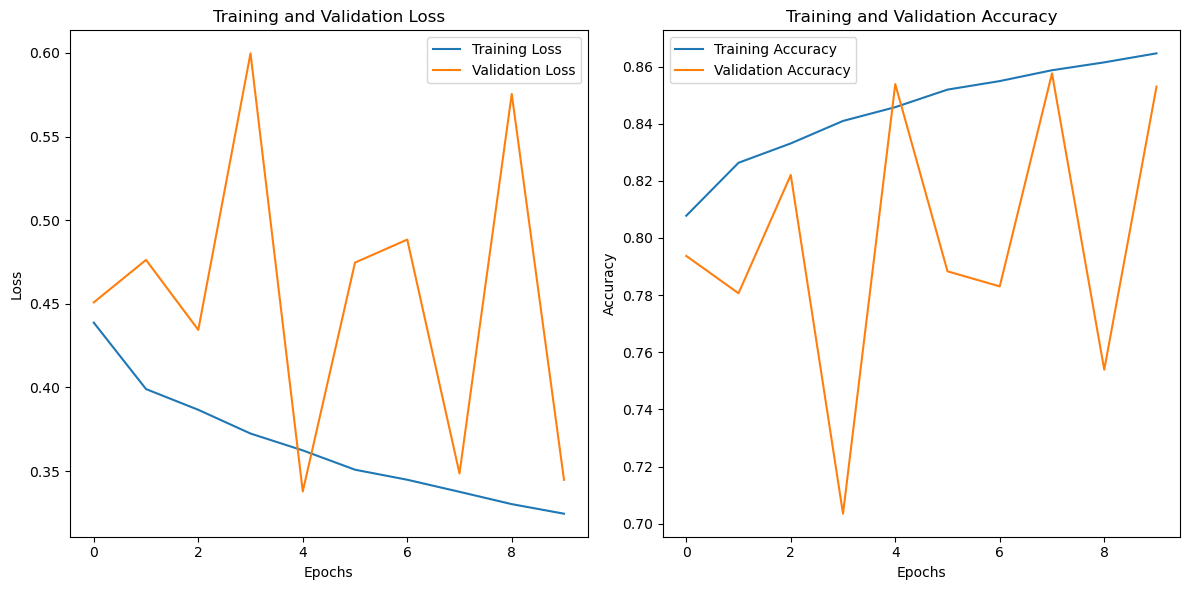

In [29]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

1376/1376 ━━━━━━━━━━━━━━━━━━━━ 18s 13ms/step


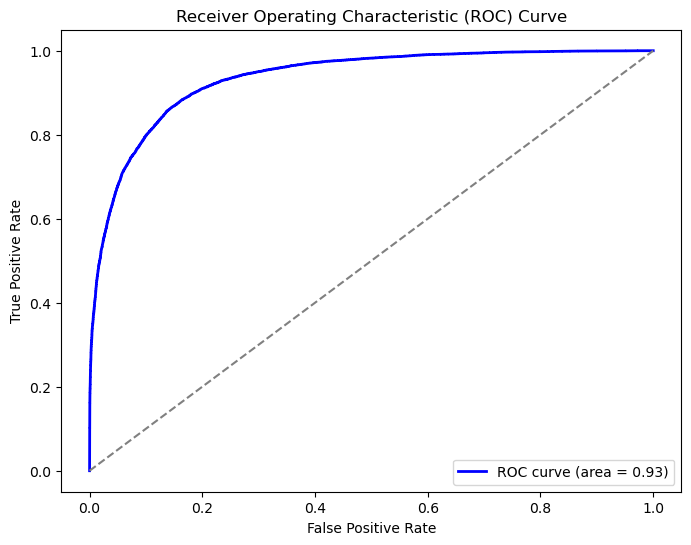

In [30]:
y_true = val_generator.classes
y_pred = model.predict(val_generator)
fpr, tpr, thresholds = roc_curve(y_true, y_pred)

roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='b', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

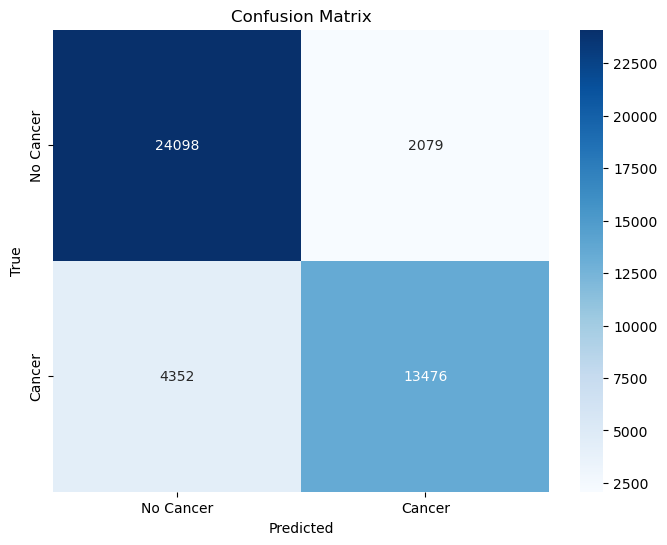

In [32]:
y_pred_rounded = (y_pred > 0.5).astype(int)

cm = confusion_matrix(y_true, y_pred_rounded)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Cancer', 'Cancer'], yticklabels=['No Cancer', 'Cancer'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [39]:
def create_submission():
    """Generate predictions and create submission file"""
    
    test_dir = 'test' 
    test_files = [f for f in os.listdir(test_dir) if f.endswith('.tif')] 
    
    test_df = pd.DataFrame({'id': test_files})
    
    test_datagen = ImageDataGenerator(rescale=1./255)  
    test_generator = test_datagen.flow_from_dataframe(
        dataframe=test_df,
        directory=test_dir,
        x_col='id',
        y_col=None,  
        target_size=(96, 96),  
        batch_size=32,
        class_mode=None,  
        shuffle=False  
    )
    
    predictions = model.predict(test_generator, verbose=1)
    
    predictions = (predictions > 0.5).astype(int) 
    
    submission = pd.DataFrame({
        'id': test_df['id'],  
        'label': predictions.flatten() 
    })
    
    submission['id'] = submission['id'].str.replace('.tif', '', regex=False)
    
    submission.to_csv('submission.csv', index=False)
    print("Submission file created!")

create_submission()

Found 57458 validated image filenames.
1796/1796 ━━━━━━━━━━━━━━━━━━━━ 22s 12ms/step
Submission file created!


### Step 5: Conclusion

In this project, I utilized a Convolutional Neural Network (CNN) to handle a binary image classification task. The model was trained using 96x96 images, but focused on the 32x32 center region of each image to reduce unnecessary complexity and improve processing efficiency.

The model achieved a training accuracy of 85.68%, with a validation accuracy of 85.39%. The AUC score during training was 0.9364, and the validation AUC score was 0.9342, which shows a strong ability to differentiate between the two classes. The final model's loss was 0.3318, with a validation loss of 0.3378.

In the Kaggle competition, the model scored 0.7781 accuracy, which was an ok result, there is definitley room for further improvement.

Next Steps for Improvement:

- Hyperparameter Tuning: Experimenting with different learning rates, batch sizes, and network architectures could enhance the model’s performance.
- Data Augmentation: While I used a range of augmentations during training, additional techniques such as rotation, flipping, or color shifting could improve the model’s ability to generalize.
- Model Ensembling: Combining predictions from multiple models could help improve accuracy, especially if each model specializes in different parts of the data.
- Transfer Learning: Using pretrained models (such as those trained on ImageNet) and fine-tuning them for this specific task might provide a performance boost. I wanted to work through training my own model for this project.

In conclusion, while the model performed well, future iterations could focus on fine-tuning these aspects to push performance even further and potentially increase the accuracy in the competition.